In [77]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [113]:
df = pd.read_excel(r"/Users/dominikorzel-walker/Documents/Online Retail.xlsx", sheet_name = 0)
                   
                   
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the above we see that we have a lot of NaN CustomerID's (and some NaN Descriptions), and to get around this we remove all such instances of no CustomerID as there isn't much other option 

In [115]:
cleaned_df = df.copy()

cleaned_df = cleaned_df[~cleaned_df.CustomerID.isna()]

In [116]:
cleaned_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


There are still some strange results about the data, for instance the minimum quantity being negative when we expect all quantity values to be positive. In fact, the negative quantity values arise from cancelled orders, as seen below by the InvoiceNo's starting with 'C'

In [117]:
df[df.Quantity < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


From the description of the dataset, we expect the InvoiceNo to be a 6-digit integral number and the StockCode to be a 5-digit integral number, so we subset for these 

In [118]:
cleaned_df.InvoiceNo = cleaned_df.InvoiceNo.astype("str")
cleaned_df.StockCode = cleaned_df.StockCode.astype("str")

cleaned_df = cleaned_df[(cleaned_df.InvoiceNo.str.match("^\\d{6}$") == True) & (cleaned_df.StockCode.str.match("^\\d{5}$") == True)]

cleaned_df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom
11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom
12,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047.0,United Kingdom
13,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047.0,United Kingdom


We now look at the country column to see if there are any strange values

In [119]:
cleaned_df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Finland', 'Austria',
       'Sweden', 'Greece', 'Singapore', 'Lebanon', 'United Arab Emirates',
       'Israel', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

The only strange values we see are 'Unspecified' and 'European Community'. We remove these since there aren't many occurrences of them

In [120]:
print(cleaned_df[cleaned_df.Country.isin(["Unspecified", "European Community"])].shape[0])

cleaned_df = cleaned_df[~cleaned_df.Country.isin(["Unspecified", "European Community"])]

274


In [121]:
cleaned_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,362845.000000,362845,362845.000000,362845.000000
mean,13.133112,2011-07-12 18:14:19.435406080,2.885618,15296.685017
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-10 11:14:00,1.250000,13969.000000
50%,6.000000,2011-08-03 11:45:00,1.690000,15159.000000
75%,12.000000,2011-10-21 15:18:00,3.750000,16794.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,188.598817,NaN,4.362508,1711.758581


So we see that by making these other changes we have fixed other previous problems such as having negative quantity 

In [122]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362845 entries, 1 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    362845 non-null  object        
 1   StockCode    362845 non-null  object        
 2   Description  362845 non-null  object        
 3   Quantity     362845 non-null  int64         
 4   InvoiceDate  362845 non-null  datetime64[ns]
 5   UnitPrice    362845 non-null  float64       
 6   CustomerID   362845 non-null  float64       
 7   Country      362845 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.9+ MB


So overall we see that by changing these columns we also fixed other previous problems we had such as empty Descriptions and negative quantities

In [201]:
print(f" {len(cleaned_df) / len(df) * 100}%") 

 66.95681378238781%


So overall we see that we retained about $70\%$ of the original data

# Feature Engineering

We want to introduce the features of **Recency** (how recently a customer has made a purchase), **Frequency** (how often a customer makes a purchase) and **Monetary Value** (how much money a customer has spent)

We first make a column 'Cost' which encapsulates the total cost of a given order

In [123]:
cleaned_df["Cost"] = cleaned_df.Quantity * cleaned_df.UnitPrice

We now group by our CustomerID's and create our three new features

In [124]:
customerid_df = cleaned_df.groupby("CustomerID", \
                                   as_index = False) \
                .agg(Frequency = ("InvoiceNo", "nunique"), \
                     MonetaryValue = ("Cost", "sum"), \
                     RecentInvoiceDate = ("InvoiceDate", "max"))


customerid_df.head(10)

,CustomerID,Frequency,MonetaryValue,RecentInvoiceDate
0,12346.0,1,77183.60,2011-01-18 10:01:00
1,12347.0,7,3653.45,2011-12-07 15:52:00
2,12348.0,4,1437.24,2011-09-25 13:13:00
3,12349.0,1,1372.42,2011-11-21 09:51:00
4,12350.0,1,258.00,2011-02-02 16:01:00
5,12352.0,7,1373.24,2011-11-03 14:37:00
6,12353.0,1,89.00,2011-05-19 17:47:00
7,12354.0,1,1062.80,2011-04-21 13:11:00
8,12355.0,1,363.10,2011-05-09 13:49:00
9,12356.0,3,2406.63,2011-11-17 08:40:00


Since the data is old, to give a benchmark of recency we will compare these most recent invoice dates to the most recent invoice date out of all

In [125]:
MostRecentInvoiceDate = customerid_df.RecentInvoiceDate.max()

customerid_df["Recency"] = (MostRecentInvoiceDate - customerid_df.RecentInvoiceDate)\
                            .dt.days

customerid_df.head(10)

,CustomerID,Frequency,MonetaryValue,RecentInvoiceDate,Recency
0,12346.0,1,77183.60,2011-01-18 10:01:00,325
1,12347.0,7,3653.45,2011-12-07 15:52:00,1
2,12348.0,4,1437.24,2011-09-25 13:13:00,74
3,12349.0,1,1372.42,2011-11-21 09:51:00,18
4,12350.0,1,258.00,2011-02-02 16:01:00,309
5,12352.0,7,1373.24,2011-11-03 14:37:00,35
6,12353.0,1,89.00,2011-05-19 17:47:00,203
7,12354.0,1,1062.80,2011-04-21 13:11:00,231
8,12355.0,1,363.10,2011-05-09 13:49:00,213
9,12356.0,3,2406.63,2011-11-17 08:40:00,22


We plan to use a K-Means algorithm to cluster the data. This algorithm will struggle (and take a lot of time) with finding the outliers in the data, so we first examine these

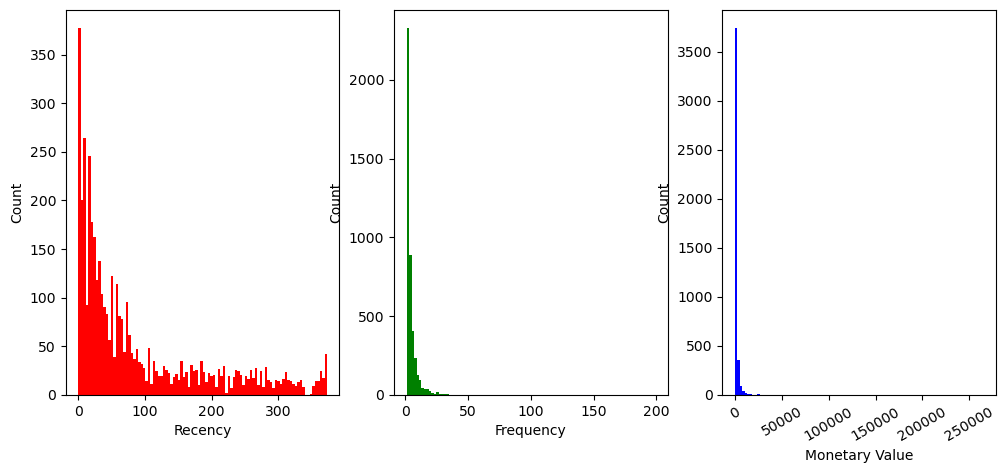

In [147]:
plt.figure(figsize = (12,5))

plt.subplot(1,3,1)
plt.hist(customerid_df.Recency, bins = 100, color = "Red")
plt.xlabel("Recency")
plt.ylabel("Count")

plt.subplot(1,3,2)
plt.hist(customerid_df.Frequency, bins = 100, color = "Green")
plt.xlabel("Frequency")
plt.ylabel("Count")

plt.subplot(1,3,3)
plt.hist(customerid_df.MonetaryValue, bins = 100, color = "Blue")
plt.xlabel("Monetary Value")
plt.ylabel("Count")
plt.xticks(rotation = 30)

plt.plot();

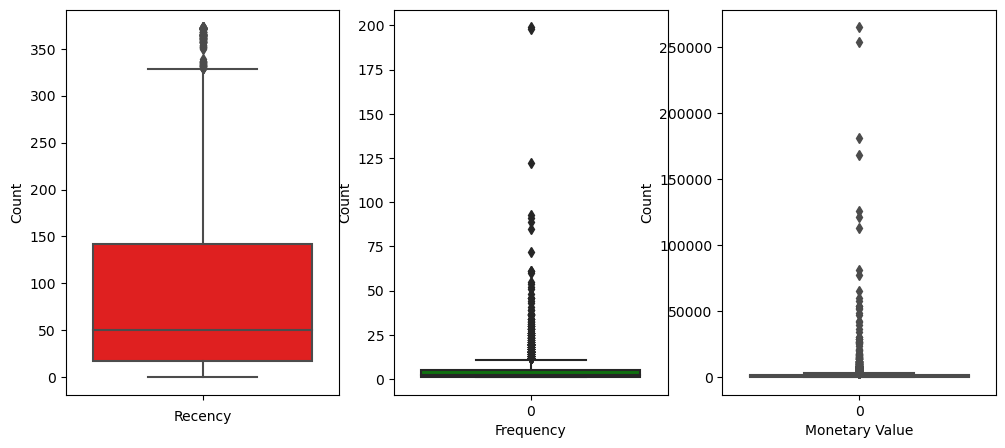

In [172]:
plt.figure(figsize = (12,5))

plt.subplot(1,3,1)
sns.boxplot(y = customerid_df.Recency, color = "Red")
plt.xlabel("Recency")
plt.ylabel("Count")

plt.subplot(1,3,2)
sns.boxplot(customerid_df.Frequency, color = "Green")
plt.xlabel("Frequency")
plt.ylabel("Count")

plt.subplot(1,3,3)
sns.boxplot(customerid_df.MonetaryValue, color = "Blue")
plt.xlabel("Monetary Value")
plt.ylabel("Count")

plt.plot();

So we see from that plots that Frequency and Monetary Value have many outliers whilst Recency not so much, so we only focus on the outliers in Frequency and Monetary Value

We now subset for the non-outlier data

In [149]:
f_q1 = customerid_df.Frequency.quantile(0.25)
f_q3 = customerid_df.Frequency.quantile(0.75)
f_iqr = f_q3 - f_q1

f_outlier_1 = customerid_df.Frequency < f_q1 - \
            1.5 * f_iqr
f_outlier_2 = customerid_df.Frequency > f_q3 + \
            1.5 * f_iqr
f_outliers = customerid_df[(f_outlier_1) | \
                            (f_outlier_2)].copy()

f_outliers.describe()

,CustomerID,Frequency,MonetaryValue,RecentInvoiceDate,Recency
count,274.000000,274.000000,274.000000,274,274.000000
mean,15361.540146,23.010949,13392.313759,2011-11-26 02:53:14.671532800,12.945255
min,12395.000000,12.000000,1128.440000,2010-12-02 15:27:00,0.000000
25%,13880.250000,13.000000,3939.572500,2011-11-24 12:40:30,2.000000
50%,15290.500000,17.000000,5933.695000,2011-12-04 11:13:00,5.000000
75%,16806.000000,25.000000,10522.685000,2011-12-07 12:18:30,14.750000
max,18283.000000,199.000000,265106.920000,2011-12-09 12:49:00,371.000000
std,1754.293469,20.861392,28642.587282,NaN,30.608013


In [204]:
mv_q1 = customerid_df.MonetaryValue.quantile(0.25)
mv_q3 = customerid_df.MonetaryValue.quantile(0.75)
mv_iqr = mv_q3 - mv_q1

outlier_1 = customerid_df.MonetaryValue < mv_q1 - \
            1.5 * mv_iqr
outlier_2 = customerid_df.MonetaryValue > mv_q3 + \
            1.5 * mv_iqr
mv_outliers = customerid_df[(outlier_1) | \
                                      (outlier_2)]

mv_outliers.describe()

,CustomerID,Frequency,MonetaryValue,RecentInvoiceDate,Recency
count,415.000000,415.000000,415.000000,415,415.000000
mean,15058.756627,16.640964,11713.042602,2011-11-16 07:42:12.867469824,22.744578
min,12346.000000,1.000000,3346.000000,2010-12-02 15:27:00,0.000000
25%,13360.500000,8.000000,4048.235000,2011-11-16 11:38:00,2.500000
50%,15032.000000,12.000000,5392.650000,2011-11-29 15:34:00,9.000000
75%,16678.000000,19.000000,8720.120000,2011-12-06 13:08:30,23.000000
max,18251.000000,199.000000,265106.920000,2011-12-09 12:49:00,371.000000
std,1805.395901,18.908341,25034.610798,NaN,44.180595


In [163]:
no_outliers_df = customerid_df[(~customerid_df.index.isin(mv_outliers.index)) & (~customerid_df.index.isin(f_outliers.index))]
                                
no_outliers_df.head(10)

,CustomerID,Frequency,MonetaryValue,RecentInvoiceDate,Recency
2,12348.0,4,1437.24,2011-09-25 13:13:00,74
3,12349.0,1,1372.42,2011-11-21 09:51:00,18
4,12350.0,1,258.00,2011-02-02 16:01:00,309
5,12352.0,7,1373.24,2011-11-03 14:37:00,35
6,12353.0,1,89.00,2011-05-19 17:47:00,203
7,12354.0,1,1062.80,2011-04-21 13:11:00,231
8,12355.0,1,363.10,2011-05-09 13:49:00,213
9,12356.0,3,2406.63,2011-11-17 08:40:00,22
11,12358.0,2,341.86,2011-12-08 10:26:00,1
13,12360.0,3,2118.36,2011-10-18 15:22:00,51


In [164]:
no_outliers_df.describe()

,CustomerID,Frequency,MonetaryValue,RecentInvoiceDate,Recency
count,3844.000000,3844.000000,3844.000000,3844,3844.000000
mean,15316.377992,2.746098,786.962003,2011-08-30 19:34:17.903225856,100.201353
min,12348.000000,1.000000,0.000000,2010-12-01 09:53:00,0.000000
25%,13844.750000,1.000000,242.902500,2011-07-01 12:19:15,21.000000
50%,15323.500000,2.000000,520.985000,2011-10-11 14:23:00,58.000000
75%,16788.250000,4.000000,1105.980000,2011-11-17 13:01:00,161.000000
max,18287.000000,11.000000,3327.530000,2011-12-09 12:50:00,373.000000
std,1707.466119,2.158692,739.699090,NaN,102.134867


We now produce updated plots to examine the non-outlier data

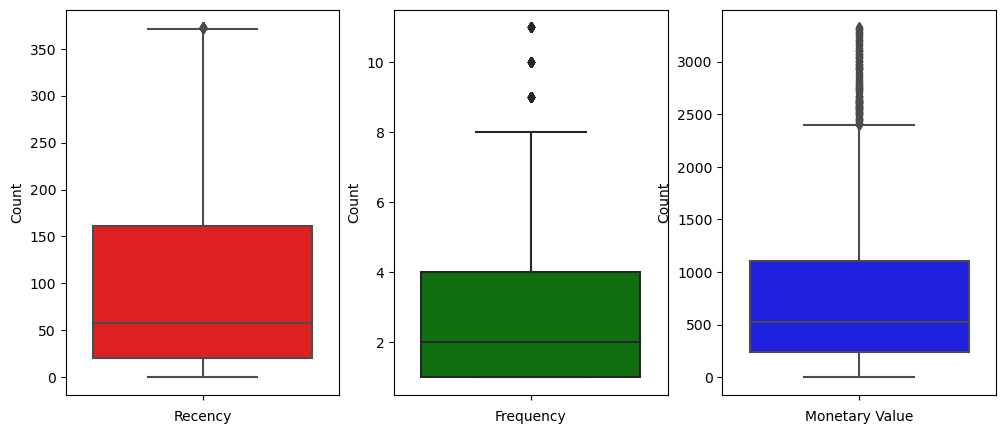

In [173]:
plt.figure(figsize = (12,5))

plt.subplot(1,3,1)
sns.boxplot(y = no_outliers_df.Recency, color = "Red")
plt.xlabel("Recency")
plt.ylabel("Count")

plt.subplot(1,3,2)
sns.boxplot(y = no_outliers_df.Frequency, color = "Green")
plt.xlabel("Frequency")
plt.ylabel("Count")

plt.subplot(1,3,3)
sns.boxplot(y = no_outliers_df.MonetaryValue, color = "Blue")
plt.xlabel("Monetary Value")
plt.ylabel("Count")

plt.plot();

Since the scales on our data are inconsistent, we fix this problem 

In [178]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(no_outliers_df[["Recency", "Frequency", "MonetaryValue"]])

scaled_data_df = pd.DataFrame(scaled_data, index = no_outliers_df.index, columns = ["Recency", "Frequency", "MonetaryValue"])

scaled_data_df.head(10)

,Recency,Frequency,MonetaryValue
2,-0.256570,0.580938,0.879226
3,-0.804936,-0.808974,0.791584
4,2.044608,-0.808974,-0.715197
5,-0.638468,1.970849,0.792693
6,1.006630,-0.808974,-0.943698
7,1.280813,-0.808974,0.372954
8,1.104552,-0.808974,-0.573094
9,-0.765767,0.117634,2.189916
11,-0.971404,-0.345670,-0.601812
13,-0.481792,0.117634,1.800153


# K-Means Algorithm

To find a good number of clusters to use for our K-Means algorithm, we use the elbow method and silhouette score values

In [179]:
inertia_vals = []
silhouette_scores = []

for cluster_num in range(2, 11):
    kmeans = KMeans(n_clusters = cluster_num, random_state = 32,\
                    max_iter = 1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    inertia_vals.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data_df, cluster_labels))

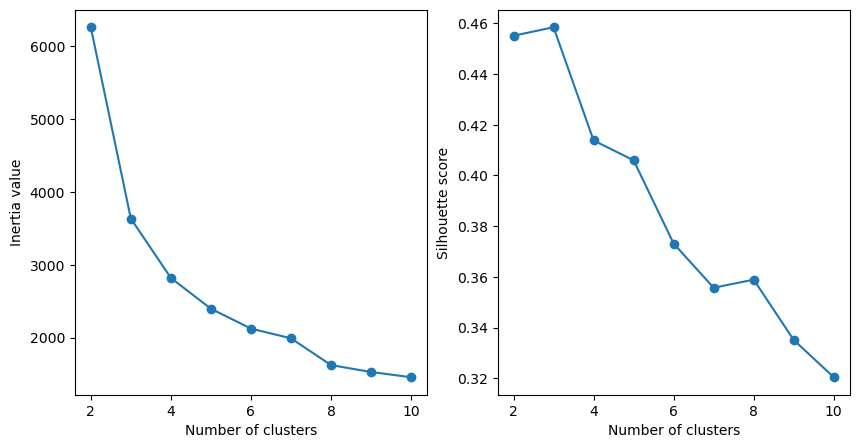

In [186]:
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.plot(range(2, 11), inertia_vals, marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia value")

plt.subplot(1,2,2)
plt.plot(range(2, 11), silhouette_scores, marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

plt.show();

We see that we have an elbow around cluster numbers 3 and 4. Given we want minimal silhouette score, we are going to choose 4 clusters

In [188]:
kmeans = KMeans(n_clusters = 4, random_state = 32, \
                max_iter = 1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

In [194]:
no_outliers_df["ClusterNumber"] = cluster_labels

no_outliers_df.head(10)

,CustomerID,Frequency,MonetaryValue,RecentInvoiceDate,Recency,Cluster number,ClusterNumber
2,12348.0,4,1437.24,2011-09-25 13:13:00,74,3,3
3,12349.0,1,1372.42,2011-11-21 09:51:00,18,2,2
4,12350.0,1,258.00,2011-02-02 16:01:00,309,0,0
5,12352.0,7,1373.24,2011-11-03 14:37:00,35,1,1
6,12353.0,1,89.00,2011-05-19 17:47:00,203,0,0
7,12354.0,1,1062.80,2011-04-21 13:11:00,231,0,0
8,12355.0,1,363.10,2011-05-09 13:49:00,213,0,0
9,12356.0,3,2406.63,2011-11-17 08:40:00,22,3,3
11,12358.0,2,341.86,2011-12-08 10:26:00,1,2,2
13,12360.0,3,2118.36,2011-10-18 15:22:00,51,3,3


Text(0.5, 0.92, 'Customer Data - Clustered')

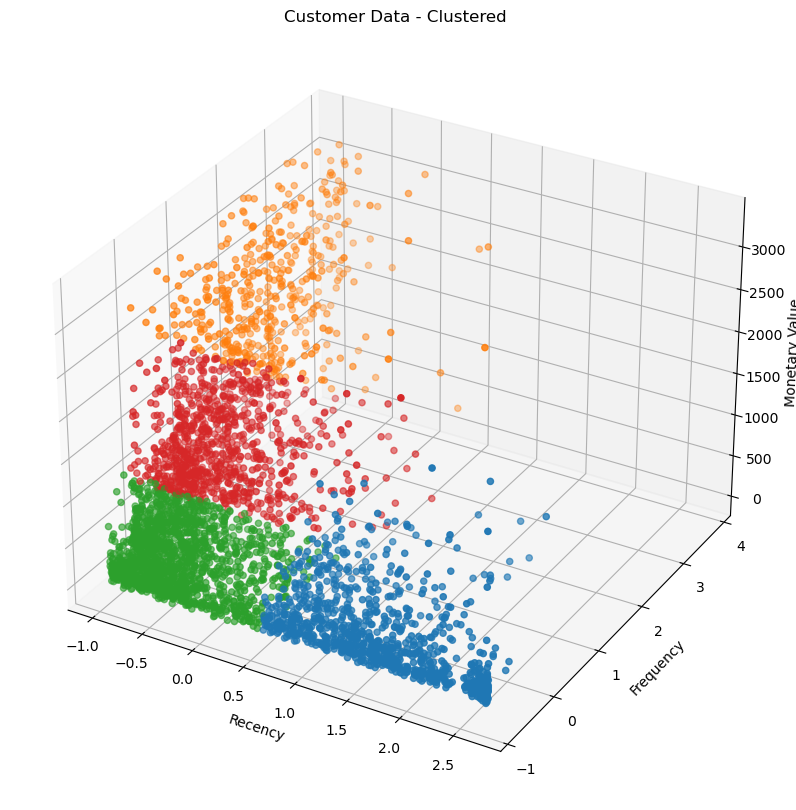

In [200]:
cluster_colors = {0: "#1f77b4", #Blue
                  1: "#ff7f0e", #Orange
                  2: "#2ca02c", #Green
                  3: "#d62728"} #Red


colors = no_outliers_df.ClusterNumber.map(cluster_colors)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = "3d")

scatter = ax.scatter(scaled_data_df.Recency, scaled_data_df.Frequency, no_outliers_df.MonetaryValue, c = colors, marker = "o")

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary Value")

ax.set_title("Customer Data - Clustered")

So from the non-outlier data, we have 4 very clear clusters, which describe 4 groups of customers:

**Blue**: Customers who have recently bought a small number of low monetary value items <br>
**Green**: Customers who have not bought for a while, but when they did they purchased a small number of low monetary value items <br>
**Red**: Customers who have not bought for a while, but when they did they purchased an average number of medium monetary value items <br>
**Orange**: Customers who have not bought for a while, but when they did they purchased a large number of big monetary value items

Whilst this data does remove outliers, it is still very useful to judge what the 'average' customer clusters look like and some recommendations can already be inferred from this 

Since there seems to be only one group who have purchased items recently, this indicates a loss of customer retention, potentially with customers purchasing from competitors instead. A new product line could be a way to try and attract customers back, or by improving the quality of past products

Additionally, since most groups are interested in buying low value products, conducting a sale may be another way of regaining customers

In [206]:
print(f"{len(no_outliers_df) / len(customerid_df) * 100}%")

89.18793503480278%


So in fact, we see that after removing the outliers, we still retained about $90\%$ of the data we were using. So the cluster plot gives a very good observation of general customer clusters for this company